## Names of group members (max 3):
    
    Kevin Vonk, s1706896



## Assignment 3 Part 1. Support Vector Machines

In [1]:
import numpy as np
import math
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt

# I need to do this because I am abusing numpy, and I need to catch a specific error
# This might not be the best way to go around it, but it works for me.
np.seterr(all="raise")

def F(x):
    ## the function that should be maximized
    fitness = -(x[:, 0]-1)**2 - (x[:, 0]-x[:, 1])**2 - (x[:, 0]-x[:, 1]-x[:, 2]-2)**2
    return fitness

We define $K$ vectors ${\bf{x}}_k$, $k=0, \ldots, K-1$ that serve all as approximations of the real maximum. Every vector in this collection has a certain fitness $f_k = F({\bf{x}}_k)$. We will apply a genetical algortithm in this notebook, in which each ${\bf{x}}_k$ is an **indiviual**.

For the time being assume these vectors are sorted according decreasing fitness. So ${\bf{x}}_0$ has the largest fitness $f_0$ and ${\bf{x}}_{K-1}$ the lowest $f_{K-1}$. Genetically the vector ${\bf{x}}_0$ is stronger ${\bf{x}}_1$, etc.

After initializing a population with random **genomes** and sorting them according to fitness, we are going to generate a new population, again of size $K$. (You will see that there are quite some choices to be made in the sequal, but, strangely enough, it does not matter so much how you choose them: this genetic algorithm works 'all the time'.) 

<ul>
    <li>
        First of all, we are going to recombine individuals $A, B$, from the current population to new individuals 
        $C$ with different genomes. function cross; 
    </li>
    <li>
        Moreover mutation is assumed to happen as well: function mutate. 
    </li> 
</ul>
In the functions below there are two numbers, $a$ and $b$, to play with. But the GA is so nice: try to come up with an alternative!

In [2]:
def cross(A, B):
    rng = np.random.default_rng()
    dim = A.shape
    C = np.ndarray(dim)
    ## take a random pick of dimension / 2 from A, the others from B
    keys = rng.choice([True, False], size=dim)

    C[keys] = A[keys]
    C[~keys] = B[~keys]
    return C

def mutate(C, replace=False):
    rng = np.random.default_rng()
    dim = C.shape
    a = 2
    b = 0.25
    offset = -1

    D = copy.deepcopy(C)
    ## for every gen take a b% chance to change the gen with a random value with amplitude a
    keys = rng.choice([True, False], size=dim, p=[b, 1-b])
    vals = a * rng.random(size=dim) + offset

    if replace:
        D[keys] = vals[keys]
    else:
        D[keys] += vals[keys]
    
    return D

These functions allow us to combine genomes of individuals. We of course now need a strategy **which individuals** are going to take part in it. As a first attempt, lets test the following genetic algorithm:

As the individuals with a low index are strong, we let the strongest $25\%$ be part of the new population as well.

For the other $75\%$ we are going to combine the genomes of two parents, $A, B$, giving an individual $C$ with  
        
            A = X_k, B = X_{k+1},   k=0, ..,K/4 - 1, so 25%
            A = X_k, B = X_r,   k=0, .., K/4 -1, r random, so 25% 
            A = X_r, B = X_s,   r, s both random, K/4 times, so 25% 

For convenience we take $K$ to be a multiple of $4$, $N=K/4$. And again: change the rules and see if you can do better than my first attempt!

The resulting algorithm may seem to be slow. However, if the number of parameters becomes (much) larger the algorithm still works more or less at the same speed.

In [3]:
def cross_and_mutate(pop, pop_size):
    rng = np.random.default_rng()
    ## pop describes the complete population: 
    ## numbers of individuals is
    size_population = pop_size[0]
    N = int(size_population/4)
    dimension = pop_size[1] 

    keys = rng.integers(0, size_population, size=(N, 3))

    offspring = copy.deepcopy(pop)
    offspring[N:2*N] = cross(pop[0:N], pop[1:N+1])
    offspring[2*N:3*N] = cross(pop[0:N], pop[keys[:, 0]])
    offspring[3*N:] = cross(pop[keys[:, 1]], pop[keys[:, 2]])

    offspring[N:] = mutate(offspring[N:])

    return offspring

In [4]:
def run(N = 6, dimension = 3, num_generations = 10000):
    rng = np.random.default_rng()
    AMP = 2
    OFFSET = -1

    size_population = 4 * N
    pop_size = (size_population, dimension)
    new_population = AMP * rng.random(size=pop_size) + OFFSET
    fitness = F(new_population)

    J = np.ndarray(num_generations) ## stores the history of the fitness
    for generation in range(num_generations):
        ## compute the fitness of each individual
        ## sort this such that the best is on top, etc 
        ## help: argsort
        fitness = F(new_population)
        # Sort keys by fitness. Since we want the highest fitness at index 0,
        # we must revert the array (np.argsort sorts by ascending value)
        sorted_keys = np.argsort(fitness)[::-1]
        fitness = fitness[sorted_keys]
        new_population = new_population[sorted_keys, :]

        J[generation] = fitness[0]
        offspring_crossover = cross_and_mutate(new_population, pop_size)
        new_population = offspring_crossover

    return fitness[0], new_population[0], J

Ended with fitness=-0.00 and a genome of [ 1.  1. -2.]


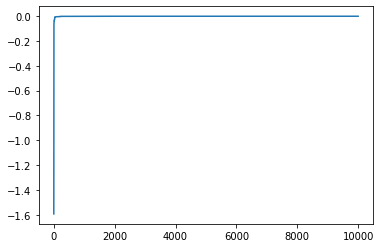

In [5]:
fitness, sol, J = run()
plt.plot(J)

with np.printoptions(precision=2, suppress=True):
    print(f"Ended with fitness={fitness:.2f} and a genome of {sol}")

This should converge to fitness = 0 best genome = [ 1, 1, -2 ]

**We have now setup the algorithm an now apply it to data sets:**

<ul>
    <li>
        The first we do by using a package **sklearn**; and also by using the genetic algorithm. 
    </li>
    <li>
        Later on you will use the package **sklearn** on more difficult data sets (to write a code that does what **sklearn** can do will take many ECs....
    </li>
</ul>


In [6]:
from scipy.io import loadmat
from sklearn.svm import SVC

The data sets below will be data in 2D with two types: $y=1$ and $y=0$ (or $-1$). 

In [7]:
def plotData(X, y, ps=60):
    pos = (y == 1).ravel()
    neg = (y <= 0).ravel()    
    plt.scatter(X[pos,0], X[pos,1], s=ps, c='k', marker='+', linewidths=1)
    plt.scatter(X[neg,0], X[neg,1], s=ps, c='y', marker='o', linewidths=1)

In [8]:
def plot_svc(svc, X, y, h=0.02, pad=0.25, ps=60, show_sv=True):
    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)
    plotData(X, y, ps=ps)
    sv = svc.support_vectors_
    if show_sv:
        plt.scatter(sv[:,0], sv[:,1], c='k', marker='|', s=100, linewidths=1)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    print('Number of support vectors: ', svc.support_.size)

### Example Dataset 1

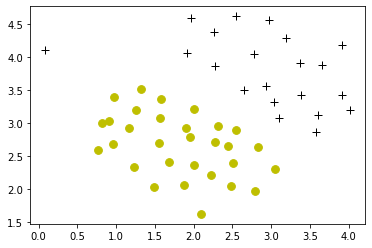

In [9]:
data1 = loadmat('../data/ex6data1.mat')
## this data sets contains 51 points, the last one has the lowest x_1 value
z1 = data1['y']
X1 = data1['X']
y1 = np.ndarray(z1.size)

keys = (z1 == 0).flatten()
y1[keys] = -1
y1[~keys] = 1

plotData(X1, y1) 

We first make the data set a little simpler: the point on the left changes identity ($1 \to -1$)

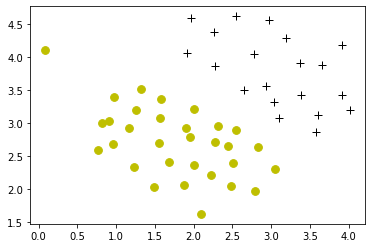

In [10]:
y1[50] = -1
plotData(X1, y1)      

This is what SVC from the package does

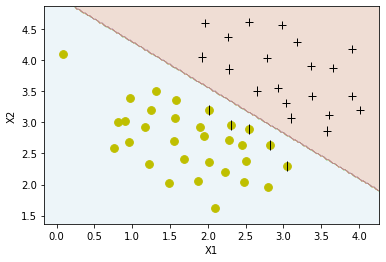

Number of support vectors:  10


In [11]:
clf = SVC(C=1.0, kernel='linear')
clf.fit(X1, y1.ravel())
plot_svc(clf, X1, y1)

**Implement the optimalisation as as defined in Eq. (4.12) in the lecture notes, ie. (7.3) in Bishop, using the genetic algorith that we already have in the run() function.**

In [12]:
def F(w): ## The fitness function is the term between the argmax{..} 
              ## of eq. (4.11) in the lecture notes or (7.3) in Bishop.
              ## read argmax{ F(inidivual) }

    PENALTY = -1000
    # This is really bad practice.
    x = X1
    y = y1

    fitness = []

    # This function originally did everything vectorised, but I needed
    # to go back to basics to get the code working. At this point I have
    # spent enough time debugging this already, so I won't re-optimise this
    # code again. It works, that's enough for me.
    for weight in w:
        gamma = y * (weight[:-1] @ x.T + weight[-1])
        keys = gamma < 0

        gamma[keys] = np.nan
        gamma = np.nanmin(gamma)
        if np.isnan(gamma):
            gamma = len(keys) * PENALTY

        fitness.append(gamma + np.count_nonzero(keys) * PENALTY)
    
    fitness = np.array(fitness)

    if fitness.shape[0] != w.shape[0]:
        raise Exception(f"Normed over wrong axis. {fitness.shape}, {w.shape}")

    return fitness

fitness, sol, J = run(num_generations=1000) ## you can reduce the number of generations: run(6, 3, 1000)
with np.printoptions(precision=2, suppress=True):
    print(f"Ended with fitness={fitness:.2f} and a genome of {sol}")

Ended with fitness=0.16 and a genome of [ 0.4   0.48 -2.58]


In [13]:
def plotData2(X, y, sol):
    pos = (y == 1).ravel()
    neg = (y == -1).ravel()    
    plt.scatter(X[pos,0], X[pos,1], s=60, c='k', marker='+', linewidths=1)
    plt.scatter(X[neg,0], X[neg,1], s=60, c='y', marker='o', linewidths=1)  
    x = np.linspace(0, 4, 100)
    plt.plot(x, -(sol[0] * x + sol[2])/sol[1], linestyle='solid')
    plt.plot(x, -(sol[0] * x + sol[2] + fitness)/sol[1], linestyle='solid')
    plt.plot(x, -(sol[0] * x + sol[2] - fitness)/sol[1], linestyle='solid')

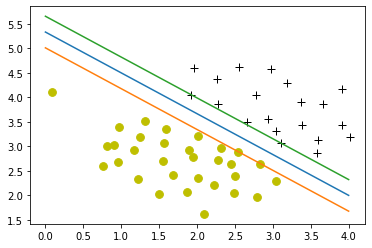

In [14]:
plotData2(X1, y1, sol)

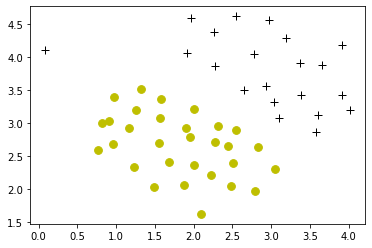

In [15]:
y1[50] = 1
#X1[50, 1] = 3
plotData(X1, y1) 

In [16]:
fitness, sol, J = run(num_generations=1000)

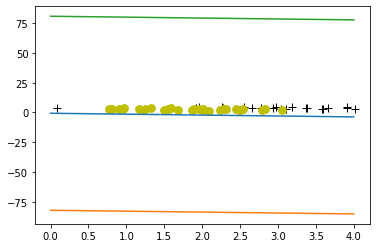

In [17]:
plotData2(X1, y1, sol)

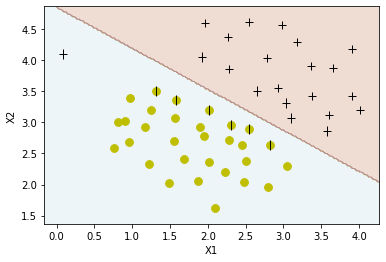

Number of support vectors:  12


In [18]:
clf = SVC(C=1, kernel='linear')
clf.fit(X1, y1.ravel())
plot_svc(clf, X1, y1)

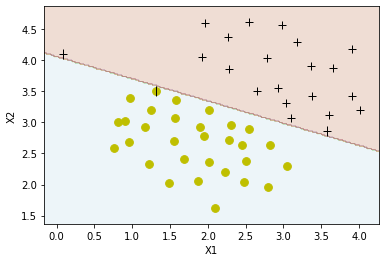

Number of support vectors:  3


In [19]:
clf = SVC(C = 100, kernel='linear')
clf.fit(X1, y1.ravel())
plot_svc(clf, X1, y1)

**Question.** Does the linear case work for C->0 and/or C->infinity work for the case that the dataset is not linearly separable? And what about the genetic code?
(Pull, e.g., the X1[50][1] -> 3, y1[50] = 1)
How would you rephrase the genetic optimization such that you could use it for the non separable case as well?

If the data is not linearly separable, my genetic optimisation produces bogus results. The fitness function penalises wrongly classified data points (i.e. $C \rightarrow \infty$), so when the data is not linearly separable, the margin grows larger than the given dataset entirely.

SKLearn however, deals with this problem quite differently. In the $C = 1$ case, misclassifications are allowed and single misclassification / non-separable datapoint doesn't alter the results much. If, however, the two classifications are completely interwoven and thus not linearly separable is still able to produce a hyperplane, but the accuracy might be questionable. A different feature set might provide better results.

In the $C = 100$ case, we see a result similar to that of my genetic algorithm. Perculiarly though, if we make one data point to be non-linearly separable, the data point seems to be ignored. No matter if the algorithm continues to do this if more data points are not linearly separable, or if it does try to find a hyperplane, the results will be meaningless due to the large $C$ parameter.

### SVM with other Kernels

Below are two more data sets. Use the package sklearn for this. Dive into the manual of this package an figure out how you can get a good classifier. Explain how the methods works with other kernels. Change parameters, such as C, degree and other basis functions: what is their effect? 

#### Example Dataset 2

In [20]:
data2 = loadmat('../data/ex6data2.mat')
data2.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [21]:
y2 = data2['y']
X2 = data2['X']

print('X2:', X2.shape)
print('y2:', y2.shape)

X2: (863, 2)
y2: (863, 1)


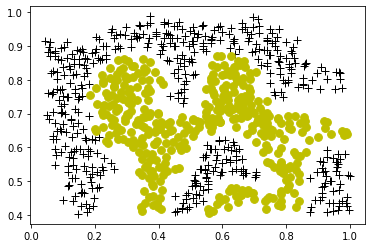

In [22]:
plotData(X2, y2)

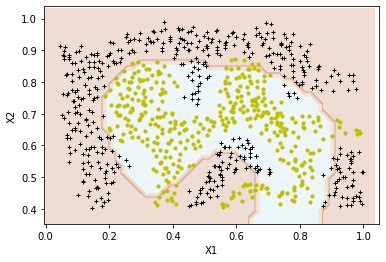

Number of support vectors:  413


In [23]:
# Underfitted
clf = SVC(C=1, kernel="rbf")
clf.fit(X2, y2)
plot_svc(clf, X2, y2, pad=0.05, ps=10, show_sv=False)

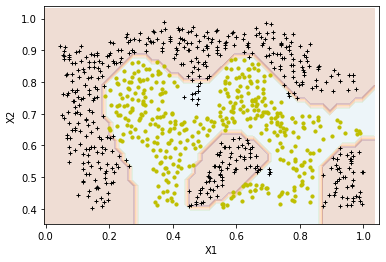

Number of support vectors:  159


In [24]:
# Decent fit
clf = SVC(C=100, kernel="rbf")
clf.fit(X2, y2)
plot_svc(clf, X2, y2, pad=0.05, ps=10, show_sv=False)

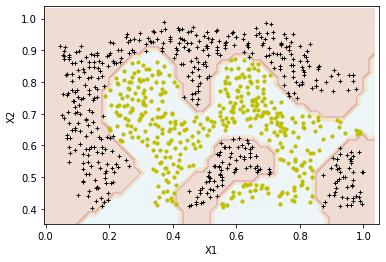

Number of support vectors:  27


In [25]:
# Overfitted
clf = SVC(C=1000000, kernel="rbf")
clf.fit(X2, y2)
plot_svc(clf, X2, y2, pad=0.05, ps=10, show_sv=False)

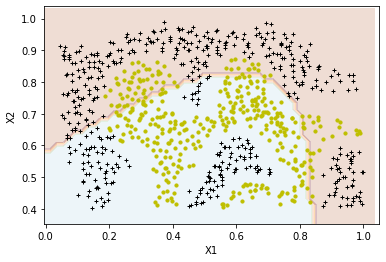

Number of support vectors:  627


In [26]:
# Wrong kernel, too few degrees
clf = SVC(C=100, kernel="poly")
clf.fit(X2, y2)
plot_svc(clf, X2, y2, pad=0.05, ps=10, show_sv=False)

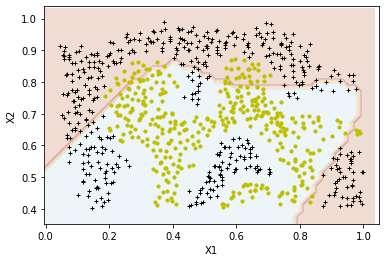

Number of support vectors:  557


In [27]:
# Wrong kernel, higher degree
clf = SVC(C=1, kernel="poly", degree=5)
clf.fit(X2, y2)
plot_svc(clf, X2, y2, pad=0.05, ps=10, show_sv=False)

From the results above we see that the choice of kernel can really make a big difference in whether you are even able to obtain a result in a decent timeframe. The default ```rbf``` kernel provides a decent fit given the right parameter $C$, following the same principles that we have previously seen. Changing the kernel to ```poly``` however, shows that no reasonable fit can be made. Additionally, increasing the amount of degrees in the polynomial drastically increases the runtime. I wasn't able to obtain a result for ```degree=6```, and even if I could, the resulting fit would not provide accurate predictions.

For this data set, I found $C=100$ and ```kernel=rbf``` to provide a decent fit of the data. The accuracy of the fit however is unknown, as there is no other data set to compare against. Higher values of $C$ provide a better fit, but we are most likely overfitting at that point. This however, is nothing but speculation.

#### Example Dataset 3

In [28]:
data3 = loadmat('../data/ex6data3.mat')
data3.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'yval', 'Xval'])

In [29]:
y3 = data3['y']
X3 = data3['X']
Xpredict = data3["Xval"]
ypredict = data3["yval"]

print('X3:', X3.shape)
print('y3:', y3.shape)

X3: (211, 2)
y3: (211, 1)


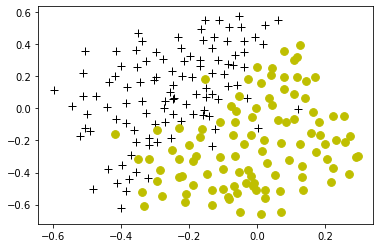

In [30]:
plotData(X3, y3)

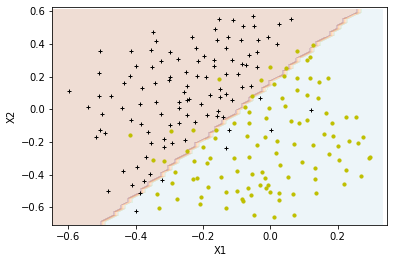

Number of support vectors:  104


In [31]:
# Decent fit
clf = SVC(C=1, kernel="linear")
clf.fit(X3, y3)
plot_svc(clf, X3, y3, pad=0.05, ps=10, show_sv=False)

In [32]:
print(f"Out of {len(ypredict)} values, we have an accuracy of {clf.score(Xpredict, ypredict)*100}%.")

Out of 200 values, we have an accuracy of 92.5%.


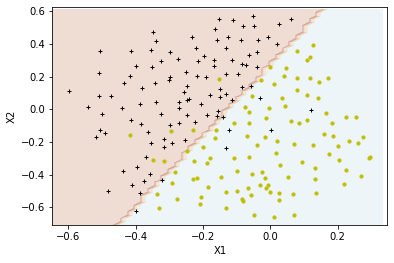

Number of support vectors:  52


In [33]:
# Possibly overfitted
clf = SVC(C=100, kernel="linear")
clf.fit(X3, y3)
plot_svc(clf, X3, y3, pad=0.05, ps=10, show_sv=False)

In [34]:
print(f"Out of {len(ypredict)} values, we have an accuracy of {clf.score(Xpredict, ypredict)*100}%.")

Out of 200 values, we have an accuracy of 92.0%.


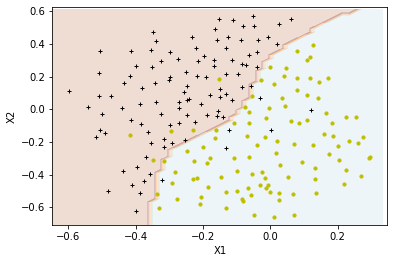

Number of support vectors:  53
Out of 200 values, we have an accuracy of 95.5%.


In [35]:
# Possibly invalid kernel
clf = SVC(C=10, kernel="rbf")
clf.fit(X3, y3)
plot_svc(clf, X3, y3, pad=0.05, ps=10, show_sv=False)
print(f"Out of {len(ypredict)} values, we have an accuracy of {clf.score(Xpredict, ypredict)*100}%.")

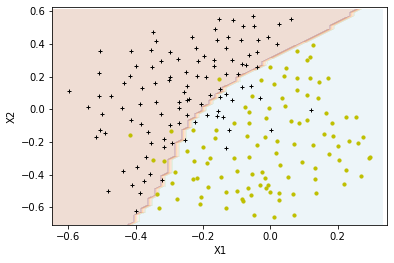

Number of support vectors:  67
Out of 200 values, we have an accuracy of 92.0%.


In [36]:
# Possibly invalid kernel
clf = SVC(C=10, kernel="poly", degree=3)
clf.fit(X3, y3)
plot_svc(clf, X3, y3, pad=0.05, ps=10, show_sv=False)
print(f"Out of {len(ypredict)} values, we have an accuracy of {clf.score(Xpredict, ypredict)*100}%.")